In [1]:
%load_ext autoreload

%autoreload 2

# New data

- preprocess the new data
- train it on just DNN
- then on CNN
- setup tensorboard for experiment tracking

# Preprocessing

In [3]:
import sklearn
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import utils

# Loading the saved model

In [16]:
loaded_sequential = utils.load_model("./models/deep_1_20231207123539.pkl")

In [78]:
labels_map = {'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'div': 10,
 'rightarrow': 11,
 'times': 12,
 'u': 13,
 'v': 14,
 'w': 15,
 'y': 16,
 'z': 17,
 '+': 18,
 '-': 19}

In [18]:
target_names = list(labels_map.keys())

In [19]:
target_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '+',
 '-',
 'div',
 'rightarrow',
 'times',
 'u',
 'v',
 'w',
 'y',
 'z']

In [43]:
def preprocess(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return img

In [44]:
img = preprocess("./equations/five.png")

In [45]:
img.shape

(303, 367)

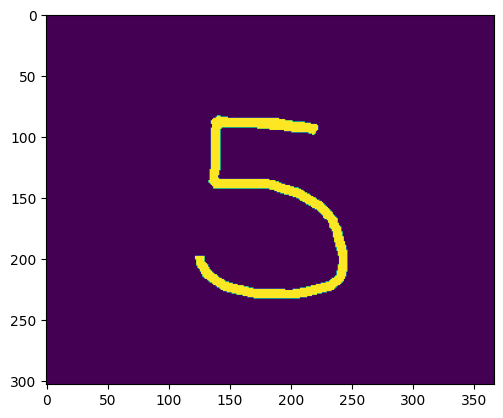

In [46]:
plt.imshow(img)

In [47]:
img.shape

(303, 367)

In [49]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [50]:
def boundingBoxes(fileName):
    # Read Input image
    inputImage = cv2.imread(fileName)
    # Deep copy for results
    inputImageCopy = inputImage.copy()
    # Convert BGR to grayscale
    grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    # Threshold via Otsu
    threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # Get each bounding box
    # Find the big contours/blobs on the filtered image
    contours, hierarchy = cv2.findContours(binaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours,_ = sort_contours(contours)
    # contours, _ = sort_contours(contours, "top-to-bottom")


    # Expand the bounding box size
    expansion_value = 10  # Increase this value to expand the bounding boxes more
    bounding_boxes = []
    # Look for the outer bounding boxes (no children)
    for _, c in enumerate(contours):
        # Get the bounding rectangle of the current contour
        boundRect = cv2.boundingRect(c)
        
        # Expand bounding box
        rectX = max(0, boundRect[0] - expansion_value)
        rectY = max(0, boundRect[1] - expansion_value)
        rectWidth = min(inputImage.shape[1] - rectX, boundRect[2] + 2 * expansion_value)
        rectHeight = min(inputImage.shape[0] - rectY, boundRect[3] + 2 * expansion_value)
        
        # Draw expanded bounding box
        color = (0, 255, 0)
        start_X = int(rectX)
        end_X = int(start_X + rectWidth)
        start_Y = int(rectY)
        end_Y = int(start_Y + rectHeight)
        contoursImage = inputImageCopy.copy()
        bounding_boxes.append(contoursImage[start_Y:end_Y, start_X:end_X])
        cv2.rectangle(inputImageCopy, (start_X, start_Y),
                    (end_X, end_Y), color, 2)

    # Show the image with expanded bounding boxes
    bb_image = cv2.cvtColor(inputImageCopy, cv2.COLOR_BGR2RGB)
    plt.imshow(bb_image)
    return bounding_boxes

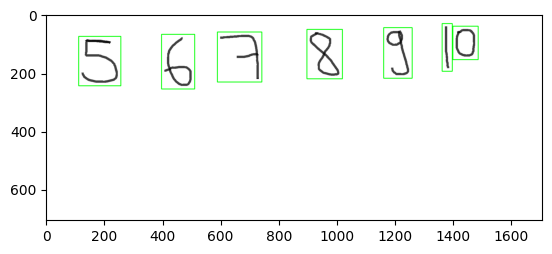

In [51]:
folder = "./equations/"
fileName = f"{folder}/nums.png"
bounding_boxes = boundingBoxes(fileName)

In [72]:
def preprocess(img):
    # img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    img = cv2.resize(img, (55, 55), cv2.INTER_CUBIC, fx=0.1, fy=0.1)
    return img

In [73]:
def idtolabel(labels_map, y):
    for key, value in labels_map.items():
        if y == value:
            return key
        
    return -1


In [74]:
def predict(model, img):
    img = np.expand_dims(img, (0,1))
    img = utils.minmax_normalize(img)
    print(img.shape, img.max())
    logits = model._forward(img)
    y_pred = np.argmax(logits, axis=1)
    return y_pred
    

In [75]:

def get_symbols(model, bounding_boxes):
    equation_string = []
    for bb in bounding_boxes:
        preprocessed_img = preprocess(bb)
        max_index = predict(model, preprocessed_img)
        labels = labels = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '-': 11, 'div': 12, 'rightarrow': 13, 'times': 14, 'u': 15, 'v': 16, 'w': 17, 'y': 18, 'z': 19}
        predicted_class = idtolabel(labels, max_index)
        print(max_index)
        equation_string.append(predicted_class)

    return equation_string



In [76]:
symbols_list = get_symbols(loaded_sequential, bounding_boxes)
print(symbols_list)

(1, 1, 55, 55) 1.0
[5]
(1, 1, 55, 55) 1.0
[2]
(1, 1, 55, 55) 1.0
[11]
(1, 1, 55, 55) 1.0
[17]
(1, 1, 55, 55) 1.0
[9]
(1, 1, 55, 55) 1.0
[4]
(1, 1, 55, 55) 1.0
[0]
['5', '2', '-', 'w', '9', '4', '0']


In [79]:
from sympy import symbols, Eq, solve

def solve_equation_sympy(expression):
    # Create symbolic variables
    x = symbols('x')

    # Convert the array to a string
    equation_string = ' '.join(map(str, expression))
    try:
        # Create a sympy equation
        equation = Eq(eval(equation_string), x)

        # Solve the equation
        result = solve(equation, x)

        return result[0] if result else None
    except (SyntaxError, TypeError, ValueError) as e:
        print(f"Error: {e}")
        return None


# Example equation as an array
equation_array = symbols_list

# Solve the equation using sympy
result = solve_equation_sympy(equation_array)

if result is not None:
        print(f"Result: {result}")

Error: invalid syntax (<string>, line 1)
